In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

import funcs.utils as utils
import funcs.plotting as plot
import funcs.amyloid as amyloid

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
PROCESSED_DIR = "data/processed"

### 1. Load Data
---

In [3]:
# Includes only continuous variables
# Comparison of multiple imputation methods
X = pd.read_csv(os.path.join(PROCESSED_DIR, "AL_for_ccp_02.tsv"), sep='\t', index_col=0).rename(columns=amyloid.ddict_unclean)

data_df = pd.read_csv(os.path.join(PROCESSED_DIR, "dataset_processed.tsv"), sep='\t', index_col=0).rename(columns=amyloid.ddict_unclean)

# Fix Dates
data_df = pd.concat([pd.to_datetime(data_df[amyloid.dates][var], format="mixed") for var in amyloid.dates], axis=1, keys=amyloid.dates).join(
    data_df.drop(amyloid.dates, axis=1)  
)

### 2. Imputation
---

* Requires running `02a_imputation.ipynb` for `mice::mice`

Methods included:
* Median imputation
* KNN imputation (K=5)
* MICE imptuation (in R)


In [5]:
from sklearn.impute import KNNImputer

# Median imputation
Xi_median = X.fillna(X.median())

# KNN Imputation
KNN_NEIGHBORS = 5

imputer = KNNImputer(n_neighbors=KNN_NEIGHBORS)

Xi_knn = pd.DataFrame(
    imputer.fit_transform(X), 
    index=X.index, 
    columns=X.columns
)

# MICE imputation
Xi_mice_dict = {}

for mice_result in glob.glob("data/imputed/mice_qvars*.tsv"):
    Xi_mice_dict[int(mice_result.split("/")[-1].split("_")[-1].split(".tsv")[0])] = pd.read_csv(
        mice_result, sep="\t").rename(columns={'X24_hr_UTP':'24_hr_UTP'}).rename(columns=amyloid.ddict_unclean)


In [9]:
# Comparison of imputation to mean
Xi_comparison = pd.DataFrame(X.mean(), index=X.columns, columns=['original']).join(
    pd.DataFrame(Xi_median.mean(), index=X.columns, columns=['median_imputed'])).join(
    pd.DataFrame(Xi_knn.mean(), index=X.columns, columns=['knn_imputed'])).join(
    pd.concat(
        [pd.DataFrame(Xi_mice_dict[k].mean(), index=X.columns, columns=['mice_imputed_{}'.format(k)]) for k,v in Xi_mice_dict.items()],
        axis=1
    )
)

Xi_comparison

,original,median_imputed,knn_imputed,mice_imputed_2,mice_imputed_3,mice_imputed_1,mice_imputed_4,mice_imputed_5
Kappa-sFLC,86.527039,69.145709,82.118573,91.346480,97.474397,92.474397,92.940984,97.539923
Lambda-sFLC,201.517277,167.661186,213.486586,208.657618,215.617261,210.271311,210.558293,214.505689
kappa:lambda ratio,6.330931,4.812604,5.990532,6.896842,7.275858,7.073987,6.969339,7.219735
dFLC,247.169942,207.143587,256.124272,259.067406,271.922276,259.966442,261.806895,271.304484
Bone marrow plasma cells (%),9.781427,9.813886,9.681196,9.716008,9.714079,9.761331,9.825458,9.700096
IVSd,12.394765,12.356316,12.450627,12.393925,12.364031,12.396818,12.450338,12.343298
LVEF,58.726644,58.935391,58.310993,58.885246,58.850048,58.670685,59.049662,58.657666
WBC,7.904541,7.896962,7.896586,7.905400,7.902893,7.894214,7.891562,7.902893
Hemoglobin,12.913500,12.913317,12.916220,12.914716,12.912401,12.910762,12.918910,12.914957
MCV,91.283824,91.279171,91.268081,91.250241,91.259884,91.302797,91.256991,91.278206


In [10]:
err = Xi_comparison.T - Xi_comparison['original']
mse = err.T**2
mse.sum(0)

original              0.000000
median_imputed    52618.727255
knn_imputed       21687.742299
mice_imputed_2    11973.423839
mice_imputed_3     8255.598725
mice_imputed_1    11895.943733
mice_imputed_4    13259.874781
mice_imputed_5     7936.830760
dtype: float64

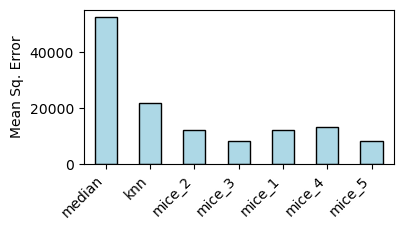

In [11]:
fig,ax = plt.subplots(figsize=(4,2))
mse.iloc[:,1:].sum().plot(kind="bar",ax=ax, linewidth=1, edgecolor='k', color='lightblue')
ax.set_xticklabels([x.replace("_imputed","") for x in mse.iloc[:,1:].columns], rotation=45, ha='right')
ax.set_ylabel("Mean Sq. Error")

plt.savefig("figures/imputation_mse.pdf", dpi=200, bbox_inches="tight")

In [12]:
Xi_mice = Xi_mice_dict[5].copy()

In [14]:
Xi_median.rename(columns=amyloid.ddict_clean).to_csv("data/imputed/median_qvars_01.tsv", sep="\t")
Xi_knn.rename(columns=amyloid.ddict_clean).to_csv("data/imputed/knn_qvars_01.tsv", sep="\t")

### Table
---

In [23]:
from tableone import TableOne

In [65]:
mse.sum()

original              0.000000
median_imputed    52618.727255
knn_imputed       21687.742299
mice_imputed_2    11973.423839
mice_imputed_3     8255.598725
mice_imputed_1    11895.943733
mice_imputed_4    13259.874781
mice_imputed_5     7936.830760
dtype: float64

In [41]:
X['data'] = "Original"
Xi_median['data'] = "Median"
Xi_knn['data'] = "KNN (K=5)"
Xi_mice_dict[5]['data'] = "MICE"

s = X.isna().sum() / X.shape[0]
columns = list(s.sort_values().index)

In [61]:
rename = {
    'Kappa-sFLC':'K (mg/L)',
    'Lambda-sFLC':'L (mg/L)', 
    'kappa:lambda ratio':'K:L',
    'dFLC':'dFLC mg/L',
    'Bone marrow plasma cells (%)':'BMPC (%)', 
    'IVSd':'IVSd (mm)', 
    'LVEF':'LVEF (%)', 
    'WBC':'WBC /mm^3', 
    'Hemoglobin':'Hgb (g/dL)',
    'MCV':'MCV (um^3)', 
    'Platelet count':'PLT /mm^2', 
    'Sed rate': 'ESR (mm/hr)', 
    'D-dimer':'D-dimer (mg/L)', 
    'Factor X':'Factor X (%)', 
    'eGFR':'eGFR (mL/min/1.72m^2)',
    '24-hr UTP':'Proteinuria (mg/24h)', 
    'Albumin':'Albumin (g/dL)', 
    'Alk phos':'ALP (U/L)', 
    'BNP':'BNP (pg/mL)', 
    'Troponin':'Troponin (ng/mL)', 
    'Calcium': 'Calcium (mg/dL)',
    'Uric acid': 'Uric Acid (mg/dL)', 
    'LDH':'LDH (U/L)', 
    'Iron':'Fe (mcg/dL)', 
    'TIBC':'TIBC (mcg/dL)', 
}

In [70]:
mse.sum()

original              0.000000
median_imputed    52618.727255
knn_imputed       21687.742299
mice_imputed_2    11973.423839
mice_imputed_3     8255.598725
mice_imputed_1    11895.943733
mice_imputed_4    13259.874781
mice_imputed_5     7936.830760
dtype: float64

In [68]:
from pandas.api.types import CategoricalDtype

X_full = pd.concat([X,Xi_median,Xi_knn,Xi_mice_dict[5]])
X_full["data"] = X_full["data"].astype(CategoricalDtype(categories=["Original","MICE","KNN (K=5)","Median"], ordered=True))

categorical = []
groupby = ["data"]
nonnormal = []

mytable = TableOne(X_full.reset_index(), columns, categorical, groupby, nonnormal, 
                   pval=True, overall=False, 
                   decimals = {'WBC':2, 'Hemoglobin':2, 'Troponin': 3, 'Calcium':2, 
                               'Bone marrow plasma cells (%)':2, 'Uric acid':2, 'Albumin':2, 'kappa:lambda ratio':2},
                   rename=rename)

mytable.to_excel('tables/supplement/imputed_values_v1.xlsx')

/Users/sanand/anaconda3/envs/r4/lib/python3.10/site-packages/tableone/tableone.py:370: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._groupbylvls = sorted(data.groupby(groupby).groups.keys())  # type: ignore
/Users/sanand/anaconda3/envs/r4/lib/python3.10/site-packages/tableone/tableone.py:927: FutureWarning: The provided callable <function mean at 0x106af0040> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_cont = pd.pivot_table(cont_data,
/Users/sanand/anaconda3/envs/r4/lib/python3.10/site-packages/tableone/tableone.py:927: FutureWarning: The provided callable <function median at 0x106c137f0> is currently using DataFrameGroupBy.median. In a future version of pan

In [69]:
from pandas.api.types import CategoricalDtype

X_full = pd.concat([X,Xi_mice_dict[5]])
X_full["data"] = X_full["data"].astype(CategoricalDtype(categories=["Original","MICE",], ordered=True))

categorical = []
groupby = ["data"]
nonnormal = []

mytable = TableOne(X_full.reset_index(), columns, categorical, groupby, nonnormal, 
                   pval=True, overall=False, 
                   decimals = {'WBC':2, 'Hemoglobin':2, 'Troponin': 3, 'Calcium':2, 
                               'Bone marrow plasma cells (%)':2, 'Uric acid':2, 'Albumin':2, 'kappa:lambda ratio':2},
                   rename=rename)

mytable.to_excel('tables/supplement/imputed_values_v2.xlsx')

/Users/sanand/anaconda3/envs/r4/lib/python3.10/site-packages/tableone/tableone.py:370: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._groupbylvls = sorted(data.groupby(groupby).groups.keys())  # type: ignore
/Users/sanand/anaconda3/envs/r4/lib/python3.10/site-packages/tableone/tableone.py:927: FutureWarning: The provided callable <function mean at 0x106af0040> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_cont = pd.pivot_table(cont_data,
/Users/sanand/anaconda3/envs/r4/lib/python3.10/site-packages/tableone/tableone.py:927: FutureWarning: The provided callable <function median at 0x106c137f0> is currently using DataFrameGroupBy.median. In a future version of pan